Epoch 0 - Loss: 0.6931 - Accuracy: 0.3705
Epoch 100 - Loss: 0.6232 - Accuracy: 0.7978
Epoch 200 - Loss: 0.5805 - Accuracy: 0.7978
Epoch 300 - Loss: 0.5539 - Accuracy: 0.7978
Epoch 400 - Loss: 0.5370 - Accuracy: 0.7978
Epoch 500 - Loss: 0.5261 - Accuracy: 0.7978
Epoch 600 - Loss: 0.5189 - Accuracy: 0.7978
Epoch 700 - Loss: 0.5141 - Accuracy: 0.7978
Epoch 800 - Loss: 0.5109 - Accuracy: 0.7978
Epoch 900 - Loss: 0.5087 - Accuracy: 0.7978
Epoch 1000 - Loss: 0.5071 - Accuracy: 0.7978
Epoch 1100 - Loss: 0.5060 - Accuracy: 0.7978
Epoch 1200 - Loss: 0.5053 - Accuracy: 0.7978
Epoch 1300 - Loss: 0.5048 - Accuracy: 0.7978
Epoch 1400 - Loss: 0.5044 - Accuracy: 0.7978
Epoch 1500 - Loss: 0.5041 - Accuracy: 0.7978
Epoch 1600 - Loss: 0.5040 - Accuracy: 0.7978
Epoch 1700 - Loss: 0.5038 - Accuracy: 0.7978
Epoch 1800 - Loss: 0.5037 - Accuracy: 0.7978
Epoch 1900 - Loss: 0.5037 - Accuracy: 0.7978
Epoch 2000 - Loss: 0.5036 - Accuracy: 0.7978
Epoch 2100 - Loss: 0.5036 - Accuracy: 0.7978
Epoch 2200 - Loss: 0.5

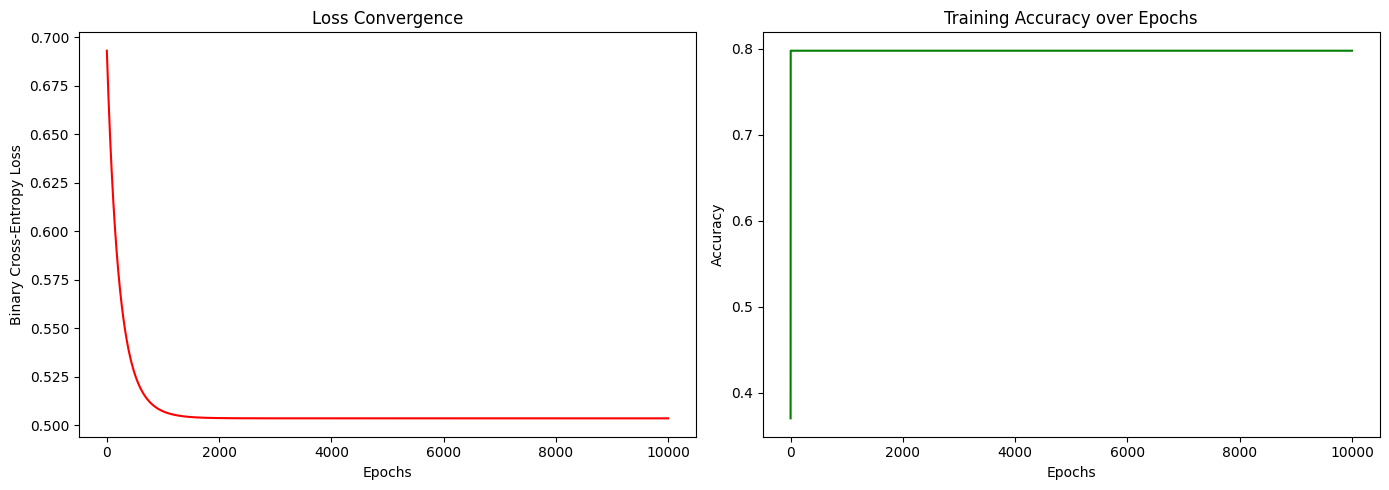

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
import time
import psutil
import os

# Load and preprocess data
df = pd.read_csv(r'C:\Users\ravik\Downloads\noshowdataset\KaggleV2-May-2016.csv')

# Target encoding
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})

# Date difference feature (in days)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['DayGap'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['DayGap'] = df['DayGap'].fillna(0).astype(int)

# Encode Gender
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# Adjust feature weights based on domain knowledge
df['DayGap'] = df['DayGap'] * 2.0  # Emphasize DayGap more
df['Scholarship'] = df['Scholarship'].apply(lambda x: -1.0 if x == 0 else 1.0)  # Adjust scholarship impact
df['DayGap_2'] = df['DayGap']  # Duplicate DayGap feature

# Simplify Handcap column
df['Handcap'] = df['Handcap'].apply(lambda x: 1 if x > 0 else 0)

# Drop unused columns
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood'], axis=1, inplace=True)

# Split data
X = df.drop('No-show', axis=1).values
y = df['No-show'].values

def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Avoid division by zero
    std[std == 0] = 1
    return (X - mean) / std

X= standardize(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return z > 0

# Loss function and derivative
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))

# Initialize weights
np.random.seed(42)
input_dim = X_train.shape[1]
W1 = np.random.randn(input_dim, 32) * 0.01
b1 = np.zeros((1, 32))
W2 = np.random.randn(32, 8) * 0.01
b2 = np.zeros((1, 8))
W3 = np.random.randn(8, 1) * 0.01
b3 = np.zeros((1, 1))

# Training loop
learning_rate = 0.01
epochs = 10000
loss_history = []
acc_history = []
start_time = time.time()
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)

for epoch in range(epochs):
    # Forward pass
    Z1 = X_train.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = relu(Z2)
    Z3 = A2.dot(W3) + b3
    A3 = sigmoid(Z3)

    # Loss and accuracy
    loss = binary_cross_entropy(y_train, A3.flatten())
    preds = (A3.flatten() > 0.5).astype(int)
    acc = accuracy_score(y_train, preds)
    
    loss_history.append(loss)
    acc_history.append(acc)

    # Backpropagation
    dZ3 = binary_cross_entropy_derivative(y_train, A3.flatten()).reshape(-1, 1) * A3 * (1 - A3)
    dW3 = A2.T.dot(dZ3) / len(X_train)
    db3 = np.mean(dZ3, axis=0, keepdims=True)

    dA2 = dZ3.dot(W3.T)
    dZ2 = dA2 * relu_derivative(A2)
    dW2 = A1.T.dot(dZ2) / len(X_train)
    db2 = np.mean(dZ2, axis=0, keepdims=True)

    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(A1)
    dW1 = X_train.T.dot(dZ1) / len(X_train)
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    # Update weights
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")

end_time = time.time()
train_time = end_time - start_time


# Evaluation on validation set
Z1 = X_val.dot(W1) + b1
A1 = relu(Z1)
Z2 = A1.dot(W2) + b2
A2 = relu(Z2)
Z3 = A2.dot(W3) + b3
y_pred_prob = sigmoid(Z3).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
pr_auc = auc(recall, precision)
cm = confusion_matrix(y_val, y_pred)
mem_after = process.memory_info().rss / (1024 ** 2)
mem_used = mem_after - mem_before


print("\n For Numpy Model Evaluation")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:\n", cm)
print(f"Memory used: {mem_used:.2f} MB")



# Plotting loss and accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, color='red')
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')

plt.subplot(1, 2, 2)
plt.plot(acc_history, color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
